In [1]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

from qiskit.providers.aer import noise
provider = IBMQ.load_account()

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Classically solve for the lowest eigenvalue
# This is used just to compare how well you VQE approximation is performing
def exact_solver(qubitOp,shift):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']+shift
    print('Reference value: {}'.format(ref))
    return ref

In [3]:
# Define your function for computing the qubit operations of LiH
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    
    # Update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    
    #Overall energy shift:
    shift = energy_shift + nuclear_repulsion_energy 

    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction, shift

In [5]:
def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
            deviation.append(std)
def get_ground_State(map_type,inter_dist,init_state,ansatz,optimizer_select):
    qubitOp, num_spin_orbitals, num_particles, \
    qubit_reduction,shift = compute_LiH_qubitOp(map_type,inter_dist=inter_dist)
    
    #Initial State
    if init_state == "Zero":
        initState = Zero(qubitOp.num_qubits)
    elif init_state == "HartreeFock":
        initState = HartreeFock(
            num_spin_orbitals,
            num_particles,
            qubit_mapping=map_type,
            two_qubit_reduction=qubit_reduction
        )
        
    #Ansatz
    depth = 10
    if ansatz == "RY":
        var_form = EfficientSU2(qubitOp.num_qubits,entanglement='full',su2_gates=['ry'],reps = 1,\
                                initial_state=initState)
    elif ansatz == "RYRZ":
        var_form = EfficientSU2(qubitOp.num_qubits,entanglement='full',su2_gates=['ry','rz'],reps = 1,\
                                initial_state=initState)
    elif ansatz == "SwapRZ":
        var_form = EfficientSU2(qubitOp.num_qubits,entanglement='full',su2_gates=['swap','rz'],reps = 1,\
                                initial_state=initState)
    elif ansatz == "UCCSD":
        var_form = UCCSD(
            num_orbitals=num_spin_orbitals,
            num_particles=num_particles,
            initial_state=initState,
            qubit_mapping=map_type
        )
        
    #Optimizer
    if optimizer_select == "COBYLA":
        optimizer = COBYLA(maxiter = 1000)
    elif optimizer_select == "SPSA":
        optimizer = SPSA(max_trials = 1000)
        
    #Noise model
    backend_ = "qasm_simulator"
    shots = 1000

    provider = IBMQ.get_provider(hub='ibm-q')
    backend = Aer.get_backend(backend_)
    device = provider.get_backend("ibmq_vigo")
    coupling_map = device.configuration().coupling_map
    noise_model = NoiseModel.from_backend(device.properties())
    quantum_instance = QuantumInstance(backend=backend, 
                                       shots=shots, 
                                       noise_model=noise_model, 
                                       coupling_map=coupling_map,
                                       measurement_error_mitigation_cls=CompleteMeasFitter,
                                       cals_matrix_refresh_period=30)
    
    #Running VQE

    
    vqe = VQE(qubitOp, var_form, optimizer, callback = store_intermediate_result)
    
    vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'] + shift)
    callbackDict = {"counts":counts,"values":values,"params":params,"deviation":deviation}
    
    return vqe_result,callbackDict,qubitOp,shift

In [6]:
map_type = "parity"
inter_dist = 1.6

# Choices of Initial State

In [7]:
initialStateList = ["Zero","HartreeFock"]

# Choices of state preparation ansatz

In [8]:
ansatzList = ["UCCSD","RY","RYRZ","SwapRZ"]

# Choices of Optimizer

In [9]:
optimizerList = ["COBYLA","SPSA"]

In [10]:
import itertools
choices = list(itertools.product(initialStateList,ansatzList,optimizerList))

In [11]:
choices[8:]

[('HartreeFock', 'UCCSD', 'COBYLA'),
 ('HartreeFock', 'UCCSD', 'SPSA'),
 ('HartreeFock', 'RY', 'COBYLA'),
 ('HartreeFock', 'RY', 'SPSA'),
 ('HartreeFock', 'RYRZ', 'COBYLA'),
 ('HartreeFock', 'RYRZ', 'SPSA'),
 ('HartreeFock', 'SwapRZ', 'COBYLA'),
 ('HartreeFock', 'SwapRZ', 'SPSA')]

In [12]:
selected_choices = choices[8:]

In [13]:
len(selected_choices)

8

In [14]:
selected_choices[0]

('HartreeFock', 'UCCSD', 'COBYLA')

# Run Algo

In [15]:
map_type = "parity"
inter_dist = 1.6

HF energy: -8.854072040283643
# of electrons: 4
# of spin orbitals: 12
Reference value: -7.881072044030919
Energy Error : 0.6268734203768664


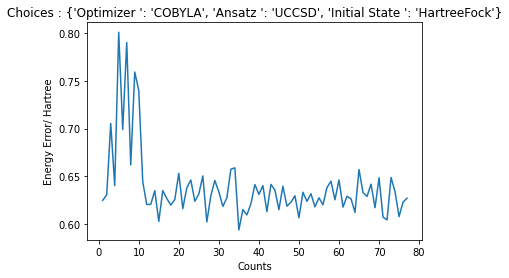

--------------------------------
HF energy: -8.854072040283645
# of electrons: 4
# of spin orbitals: 12
Reference value: -7.881072044030914
Energy Error : 0.6304252903425089


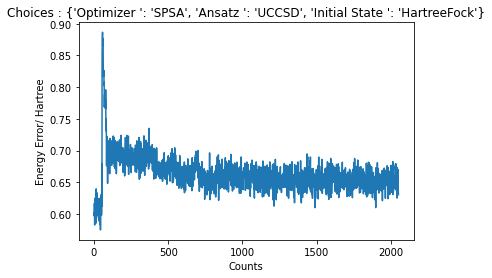

--------------------------------
HF energy: -8.854072040283649
# of electrons: 4
# of spin orbitals: 12
Reference value: -7.881072044030917
Energy Error : 0.1705436299127614


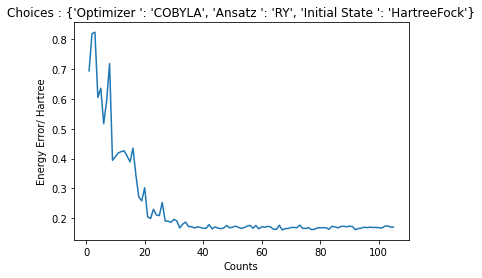

--------------------------------
HF energy: -8.854072040283645
# of electrons: 4
# of spin orbitals: 12


In [ ]:
for i in selected_choices:
    counts = []
    values =[]
    params =[]
    deviation = []
    init_state = i[0]
    ansatz = i[1]
    optimizer_select = i[2]
    
    chosen = str({"Optimizer ":optimizer_select,"Ansatz ":ansatz,"Initial State ":init_state})
    
    vqe_result,callbackDict,qubitOp,shift = get_ground_State(map_type,inter_dist,init_state,ansatz,optimizer_select)
    
    ref = exact_solver(qubitOp , shift)
    energy_error = np.abs(np.real(ref) - vqe_result)
    print("Energy Error :",energy_error)
    # Calculating energy error
    vqe_energies = np.real(callbackDict["values"]) + shift
    energy_errors = np.abs(np.real(ref) - vqe_energies)
    plt.plot(callbackDict["counts"] , energy_errors)
    plt.xlabel('Counts')
    plt.ylabel('Energy Error/ Hartree')
    plt.title("Choices : "+chosen)
    plt.show()
    print("--------------------------------")